C-NOT gate teleportation using dynamic circuit

Map the problem to circuits and operators

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.classical import expr

def get_dynamic_circuit(num_qubit):
    num_ancilla = num_qubit - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubit)
    cr1 = ClassicalRegister(num_ancilla_pair, name="cr1")
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name="cr2")
    cr3 = ClassicalRegister(2, name="cr3")
    qc = QuantumCircuit(qr, cr1, cr2, cr3)
    qc.h(0)
    qc.barrier()

    qc.cx(0,1)

    for i in range(num_ancilla_pair):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)

    for i in range(num_ancilla_pair+1):
        qc.cx(1+2*i, 1+2*i+1)

    for i in range(num_ancilla_pair+2):
        qc.h(2*i-1)
    
    for i in range(1, num_ancilla_pair+2):
        qc.measure(2 * i - 1, cr2[i-1])
        if i == 1:
            parity_control = expr.lift(cr2[i-1])
        else: 
            parity_control = expr.bit_xor(cr2[i-1], parity_control)
    
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, cr1[i])
        if i == 0:
            parity_target = expr.lift(cr1[i])
        else: 
            parity_target = expr.bit_xor(cr1[i], parity_target)
    with qc.if_test(parity_control):
        qc.z(0)
    
    with qc.if_test(parity_target):
        qc.x(-1)

    return qc
        

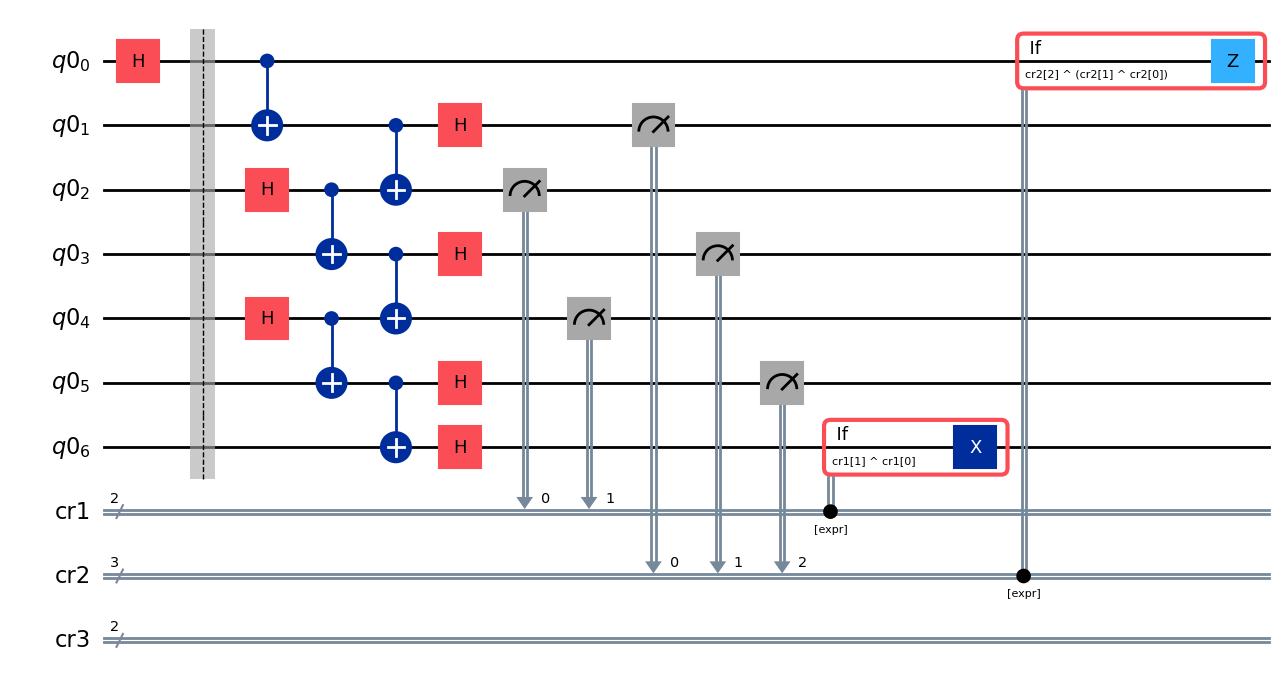

In [2]:
qc = get_dynamic_circuit(num_qubit=7)
qc.draw("mpl")

In [4]:
max_num_qubit = 41
qc_list = []
num_qubit_list = list(range(7, max_num_qubit+1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_circuit(num_qubit))

Optimize the problem for quantum execution


In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc_transpiled = pass_manager.run(qc_list)


Execute the circuit

In [7]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run(qc_transpiled)
print(job.job_id())

cxsb344y1ae0008n3s3g


Plotting

In [ ]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
job = service.job(job_id=job.job_id)

result = job.result()

list_bell = []
list_other = []

for i in range (0, len(qc_list)):
    data = result[i+1].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots
    
    prob_bell = (counts['00'] + counts['11']) / total_counts

    list_bell.append(prob_bell)
    list_other.append(1-prob_bell)

plt.plot(num_qubit_list, list_bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')

plt.legend()

